In [61]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

## analysis imports
from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class
from fund.fund import Fund

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [62]:
backtest_start_date = datetime(2015,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [63]:
market = Market()

In [64]:
portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
# portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)
# portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)
# portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)

portfolios = []
portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
# portfolios.append(portfolio_iv)
# portfolios.append(portfolio_v)
# portfolios.append(portfolio_vi)

In [65]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [66]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [67]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [84]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    try:
        trade = portfolio.db.retrieve("trades")
        trade["positions"] = int(portfolio.pricer_class.positions / 5)
        trade["portfolio"] = portfolio.name
        trade = trade[trade["position"] <= int(portfolio.pricer_class.positions / 5)]
        trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
        trades.append(trade)
    except:
        continue
    portfolio.db.disconnect()

In [85]:
t = pd.concat(trades)
t = t[(t["year"]>=backtest_start_date.year) & (t["year"]<backtest_end_date.year)]

In [86]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [87]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [88]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'floor_value',
 'portfolio',
 'pricer_timeframe']

In [89]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:35<00:00,  2.04it/s]


In [90]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
126,True,True,False,False,False,1.15,1,15,none,1.0,wsr_n_n_b_r,week,6.388937,-0.037824,0.982323,-142.463879
126,True,True,False,False,False,1.15,1,15,flat,1.0,wsr_n_n_b_r,week,6.332132,-0.040852,0.980881,-130.515594
126,True,True,False,False,False,1.15,1,15,none,0.5,wsr_n_n_b_r,week,5.542394,-0.059036,0.972215,-76.937031
126,True,True,False,False,False,1.15,1,15,flat,0.5,wsr_n_n_b_r,week,5.485637,-0.058692,0.972379,-76.420824
126,True,True,False,False,False,1.15,1,15,none,1.0,wsw_n_n_b_r,week,4.820558,-0.079892,0.962277,-47.817365
126,True,True,False,False,False,1.15,1,15,none,0.5,wsw_n_n_b_r,week,4.820558,-0.079892,0.962277,-47.817365
124,True,True,False,False,False,1.15,1,15,flat,0.5,wsw_n_n_b_r,week,4.560913,-0.123468,0.942437,-28.837867
124,True,True,False,False,False,1.15,1,15,flat,1.0,wsw_n_n_b_r,week,4.560913,-0.123468,0.942437,-28.837867
383,True,True,False,False,False,1.15,1,5,none,0.5,wsr_n_n_b_r,week,3.985972,0.100016,1.046414,29.851496
383,True,True,False,False,False,1.15,1,5,flat,0.5,wsr_n_n_b_r,week,3.985079,0.086521,1.040198,34.497277


In [91]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,pricer_timeframe,pv,beta,rrr,sharpe
0,wsr_n_n_b_r,True,True,False,False,False,1.15,1,15,none,1.0,week,6.388937,-0.037824,0.982323,-142.463879
1,wss_n_n_b_r,True,True,False,False,False,1.15,1,5,rrr,0.5,week,3.560342,0.022387,1.010685,114.352743
2,wsw_n_n_b_r,True,True,False,False,False,1.15,1,15,none,1.0,week,4.820558,-0.079892,0.962277,-47.817365


In [92]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

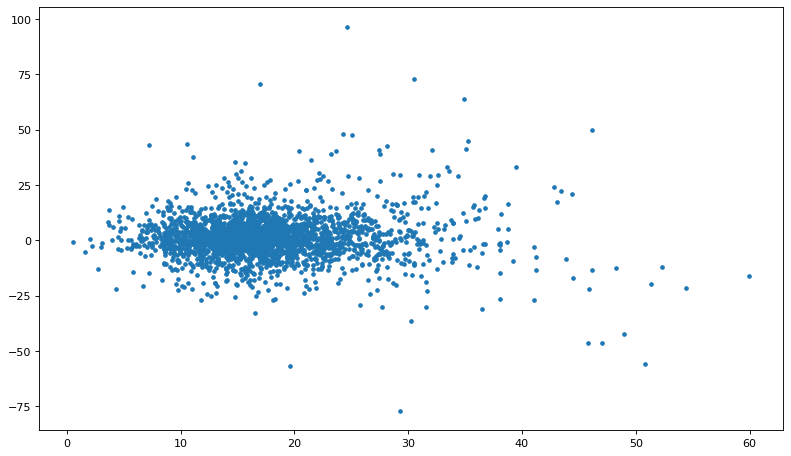

In [93]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [94]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2015,6,ABMD,0.362415,1.0,1.137644,0,Health Care,Abiomed
127,2015,6,EA,0.226103,1.0,1.052641,1,Communication Services,Electronic Arts
254,2015,6,SWKS,0.210467,1.0,1.066367,2,Information Technology,Skyworks Solutions
381,2015,6,ALK,0.192495,1.0,0.976340,3,Industrials,Alaska Air Group
508,2015,6,DXCM,0.181015,1.0,1.034629,4,Health Care,Dexcom
635,2015,6,UAL,0.171884,1.0,1.010593,5,Industrials,United Airlines Holdings
762,2015,6,INCY,0.160880,1.0,1.127567,6,Health Care,Incyte
889,2015,6,NEM,0.155434,1.0,1.058083,7,Materials,Newmont
1016,2015,6,KR,0.150622,1.0,1.028889,8,Consumer Staples,Kroger
1143,2015,6,STZ,0.147850,1.0,1.025332,9,Consumer Staples,Constellation Brands


In [95]:
ledger["actual_returns"].mean()

1.0128633964514586

In [96]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5626175253854833

In [97]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [98]:
ledger[ledger["position"]==6].head(50)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
762,2015,6,INCY,0.160880,1.0,1.127567,6,Health Care,Incyte
763,2015,9,SWKS,0.204797,1.0,1.103538,6,Information Technology,Skyworks Solutions
764,2015,12,EPAM,0.175106,1.0,1.083428,6,Information Technology,EPAM Systems
765,2015,15,SWKS,0.161300,1.0,0.976906,6,Information Technology,Skyworks Solutions
766,2015,18,HAS,0.158183,1.0,1.016783,6,Consumer Discretionary,Hasbro
767,2015,21,LYB,0.149109,1.0,1.035859,6,Materials,LyondellBasell
768,2015,24,ANET,0.145827,1.0,1.024568,6,Information Technology,Arista Networks
769,2015,27,TSLA,0.145496,1.0,0.998546,6,Consumer Discretionary,"Tesla, Inc."
770,2015,30,HAS,0.158541,1.0,0.989618,6,Consumer Discretionary,Hasbro
771,2015,33,UAA,0.146032,1.0,0.940155,6,Consumer Discretionary,Under Armour (Class A)


In [99]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [100]:
cumulative.head(50)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,1.137644,1.052641,1.066367,0.976340,1.034629,1.010593,1.127567,1.058083,1.028889,1.025332,...,0.894772,1.049084,1.068835,2015,6,1.044093,2021.01,1.000000,2015-W6,2015-02-06
1,1.122705,1.036149,1.094782,0.983909,0.972596,0.982703,1.244313,1.062080,1.129832,0.879752,...,0.904938,1.008365,1.215920,2015,9,1.047507,2101.94,1.040044,2015-W9,2015-02-27
2,1.300298,1.016490,1.096582,0.969119,0.923873,1.040166,1.348124,1.093102,1.104607,0.904527,...,0.915655,1.037410,1.287041,2015,12,1.065956,2056.64,1.017630,2015-W12,2015-03-20
3,1.248085,1.022911,1.073568,0.916533,1.080197,0.929125,1.316991,0.873944,1.108406,0.867041,...,0.926056,0.979245,1.284876,2015,15,1.041170,2070.20,1.024339,2015-W15,2015-04-10
4,1.491922,1.119959,1.054563,0.931323,1.050013,1.009817,1.339094,0.775323,1.129759,0.879633,...,0.938640,1.063480,1.319010,2015,18,1.058816,2107.25,1.042672,2015-W18,2015-05-01
5,1.374519,1.219187,1.112354,0.907921,1.019841,1.024363,1.387112,0.718208,1.095866,0.867096,...,0.911983,1.086327,1.332322,2015,21,1.054947,2109.35,1.043711,2015-W21,2015-05-22
6,1.390522,1.237631,1.002902,0.896379,1.068682,1.023835,1.421190,0.715390,1.062621,0.887848,...,1.005395,1.081182,1.262788,2015,24,1.052297,2104.81,1.041464,2015-W24,2015-06-12
7,1.296705,1.421218,1.191534,0.957236,1.098721,1.016054,1.419124,0.722590,0.943406,0.891271,...,1.003546,1.087826,1.384699,2015,27,1.070933,2111.89,1.044968,2015-W27,2015-07-03
8,1.414608,1.493647,1.182880,0.851741,1.100808,1.152842,1.404390,0.634525,0.923186,0.848061,...,1.011263,0.995542,1.013165,2015,30,1.051202,2113.38,1.045705,2015-W30,2015-07-24
9,1.219255,1.372764,1.185429,0.779897,1.036278,1.003731,1.320345,0.595069,0.845584,0.805145,...,0.868930,0.943539,0.943256,2015,33,0.968363,2090.47,1.034369,2015-W33,2015-08-14


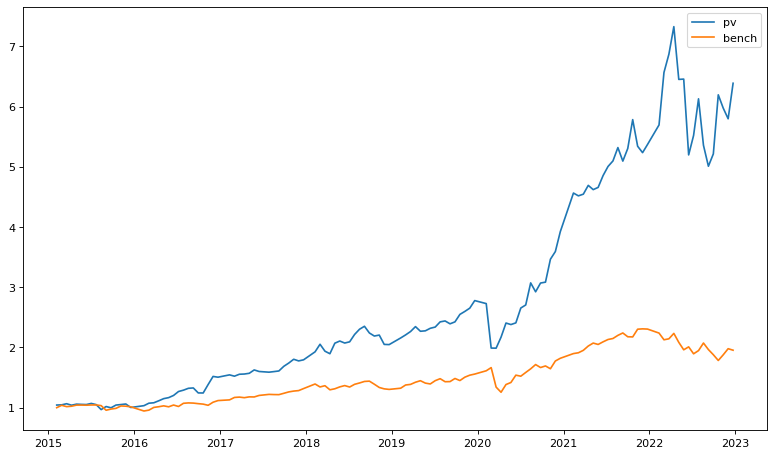

In [101]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [102]:
cumulative.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
107,1.732865,2.882152,4.650786,2.085475,9.389743,3.229676,54.548366,0.637783,1.264935,2.397457,...,5.516201,1.392930,1.911720,2021,42,5.784748,4397.05,2.175670,2021-W42,2021-10-22
108,1.853920,2.425003,4.769418,2.088135,8.717370,3.159063,49.846629,0.631042,1.115456,2.185486,...,5.495470,1.379963,1.746416,2021,45,5.342655,4656.50,2.304046,2021-W45,2021-11-12
109,1.649822,2.208794,4.863858,1.578630,7.146925,3.164317,50.937592,0.630047,0.913148,2.429473,...,5.568888,1.318846,1.977004,2021,48,5.236034,4667.43,2.309454,2021-W48,2021-12-03
110,1.585452,2.130955,4.878826,1.519417,8.918167,3.062513,51.744411,0.663575,0.947929,2.405033,...,5.844598,1.243687,2.061389,2021,51,5.371689,4660.44,2.305996,2021-W51,2021-12-24
111,1.650002,2.329654,4.949768,1.867705,9.334769,3.528366,55.819281,0.760279,0.956214,2.681812,...,6.422619,1.193303,2.000561,2022,6,5.696386,4525.89,2.239420,2022-W6,2022-02-11
112,1.717226,2.956080,6.323394,2.012128,10.782516,3.687565,67.782976,0.826133,0.922665,2.814852,...,6.958381,1.167664,2.207942,2022,9,6.568260,4300.90,2.128094,2022-W9,2022-03-04
113,1.702829,3.397152,6.944351,2.144498,10.717596,3.928319,70.559870,0.848343,0.950330,2.774103,...,7.484111,1.220935,2.125576,2022,12,6.871816,4333.64,2.144294,2022-W12,2022-03-25
114,1.514227,3.536738,6.451759,2.065835,9.690690,3.766343,81.503240,0.894199,0.933951,2.981530,...,6.841076,1.184083,2.026423,2022,15,7.329184,4515.48,2.234269,2022-W15,2022-04-15
115,1.561885,3.884799,4.720992,2.171075,8.314878,3.978889,66.537411,0.917332,1.001879,2.976957,...,6.732662,1.106690,2.082585,2022,18,6.452707,4214.94,2.085561,2022-W18,2022-05-06
116,1.449796,4.012718,4.441498,2.147757,8.311917,4.044318,69.603441,0.783167,1.007080,2.971796,...,6.309208,0.972889,1.847879,2022,21,6.458021,3964.54,1.961663,2022-W21,2022-05-27


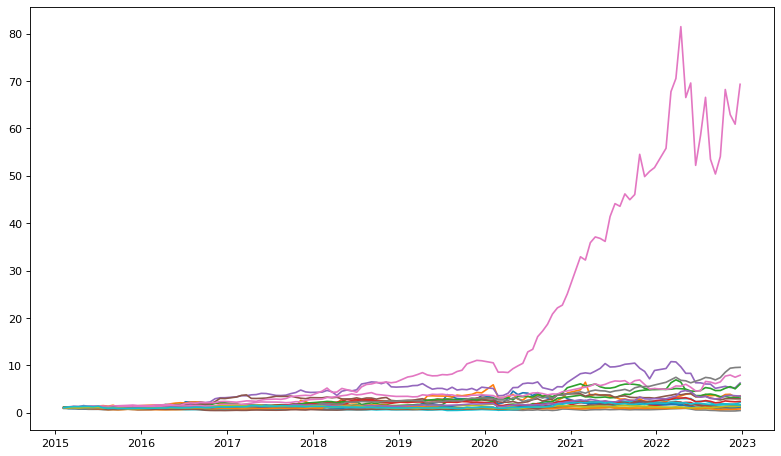

In [103]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [104]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Financials,2018.288889,33.711111,0.164204,1.0,1.034037,12.740741
Information Technology,2018.174652,28.238022,0.187270,1.0,1.018673,9.168470
Health Care,2018.537349,28.040964,0.173883,1.0,1.014767,9.775904
Materials,2018.672727,27.490909,0.180909,1.0,1.014537,10.351515
Consumer Discretionary,2018.380846,30.233853,0.180281,1.0,1.014334,9.766147
Industrials,2018.620536,30.629464,0.170457,1.0,1.009629,11.334821
Energy,2020.178295,24.895349,0.183346,1.0,1.007620,9.399225
Utilities,2017.589286,25.125000,0.137598,1.0,1.000809,10.803571
Real Estate,2018.840909,27.477273,0.132287,1.0,0.997205,13.886364


In [105]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  weekly_delta_sign  \
year week ticker Security                                                  
2017 45   ENPH   Enphase                     0.246270                1.0   
2020 33   TSLA   Tesla, Inc.                 0.304913                1.0   
2018 9    ENPH   Enphase                     0.169813                1.0   
2019 30   ENPH   Enphase                     0.348794                1.0   
2020 18   MRNA   Moderna                     0.461912                1.0   
2019 18   ENPH   Enphase                     0.242709                1.0   
2020 27   TSLA   Tesla, Inc.                 0.250652                1.0   
     15   MRNA   Moderna                     0.352722                1.0   
2018 6    ENPH   Enphase                     0.105870                1.0   
2022 30   EPAM   EPAM Systems                0.072370                1.0   
2018 33   AMD    AMD                         0.281485                1.0   
2021 6    WBD    Warner Bros. Discovery      0.351069                1.0   
     27   MRNA   Moderna                     0.274443                1.0   
2016 27   AMD    AMD                         0.321326                1.0   
2020 6    ENPH   Enphase                     0.236913                1.0   
2019 30   SEDG   SolarEdge                   0.203837                1.0   
2020 24   ETSY   Etsy                        0.232363                1.0   
     48   MRNA   Moderna                     0.275065                1.0   
     15   DXCM   Dexcom                      0.110734                1.0   
2018 18   ENPH   Enphase                     0.214930                1.0   
2022 30   ENPH   Enphase                     0.148160                1.0   
2020 45   MOS    The Mosaic Company          0.157039                1.0   
     51   ENPH   Enphase                     0.334401                1.0   
2021 9    PARA   Paramount Global            0.394608                1.0   
2020 45   GM     General Motors              0.153525                1.0   
2021 6    MRO    Marathon Oil                0.336049                1.0   
2020 45   SEDG   SolarEdge                   0.221817                1.0   
          ENPH   Enphase                     0.286845                1.0   
2016 45   NVDA   Nvidia                      0.148442                1.0   
2020 27   MRNA   Moderna                     0.293185                1.0   

                                         actual_returns  position  
year week ticker Security                                          
2017 45   ENPH   Enphase                       1.965753         1  
2020 33   TSLA   Tesla, Inc.                   1.728221         9  
2018 9    ENPH   Enphase                       1.706093        11  
2019 30   ENPH   Enphase                       1.637150         0  
2020 18   MRNA   Moderna                       1.496867         0  
2019 18   ENPH   Enphase                       1.482072         1  
2020 27   TSLA   Tesla, Inc.                   1.474639         3  
     15   MRNA   Moderna                       1.448157         0  
2018 6    ENPH   Enphase                       1.437229        17  
2022 30   EPAM   EPAM Systems                  1.428754        16  
2018 33   AMD    AMD                           1.424076         0  
2021 6    WBD    Warner Bros. Discovery        1.412644         3  
     27   MRNA   Moderna                       1.407817         0  
2016 27   AMD    AMD                           1.407258         0  
2020 6    ENPH   Enphase                       1.405691         1  
2019 30   SEDG   SolarEdge                     1.405604         2  
2020 24   ETSY   Etsy                          1.390991         9  
     48   MRNA   Moderna                       1.390321         7  
     15   DXCM   Dexcom                        1.377967        10  
2018 18   ENPH   Enphase                       1.364532         1  
2022 30   ENPH   Enphase                       1.355576         0  
2020 45   MOS    The Mosaic Company         

In [106]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2015,6,0.973707,1.058875,1.027111,1.000000,1.000000,1.069839,1.002349,1.091969,1.058083,0.958724,1.000000
1,4060225,54,0.886736,1.046558,1.027111,0.972403,1.000000,1.121358,1.010120,1.112635,1.022626,0.958724,1.000000
2,8181353375,648,0.886736,1.049196,1.040569,0.972403,1.009577,1.165022,1.013431,1.110601,0.999794,0.958724,1.000000
3,16485427050625,9720,0.708952,1.069567,1.026262,0.975747,1.036760,1.139332,0.983333,1.076317,0.998112,0.958724,1.000000
4,33218135507009375,174960,0.702582,1.133690,0.950135,0.923621,1.050848,1.180089,0.983333,1.099036,0.997425,0.958724,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0,0,0.459947,2.406930,0.917088,0.768611,1.968105,2.523500,0.771215,15.564652,2.124076,0.898374,0.920364
123,0,0,0.503105,2.703373,0.918658,0.877756,2.082122,2.702412,0.771215,15.564652,2.124076,0.898374,0.931322
124,0,0,0.503105,2.777538,0.918658,0.836828,2.074542,2.785364,0.791561,15.564652,2.124076,0.898374,1.024138
125,0,0,0.480290,2.657424,0.918658,0.801845,2.038449,2.820002,0.780963,15.564652,2.133947,0.898374,1.024138
